11490434/11490434 [==============================] - 1s 0us/step

Start of epoch 0
Training loss (for one batch) at step 0: 0.2299
Seen so far: 32 samples
1/1 [==============================] - 0s 21ms/step
Training loss (for one batch) at step 200: 0.0110
Seen so far: 6432 samples
1/1 [==============================] - 0s 24ms/step
Training loss (for one batch) at step 400: 0.0067
Seen so far: 12832 samples
1/1 [==============================] - 0s 22ms/step
Training loss (for one batch) at step 600: 0.0050
Seen so far: 19232 samples
1/1 [==============================] - 0s 20ms/step
Training loss (for one batch) at step 800: 0.0039
Seen so far: 25632 samples
1/1 [==============================] - 0s 20ms/step
Training loss (for one batch) at step 1000: 0.0039
Seen so far: 32032 samples
1/1 [==============================] - 0s 22ms/step
Training loss (for one batch) at step 1200: 0.0036
Seen so far: 38432 samples
1/1 [==============================] - 0s 22ms/step
Training loss (for

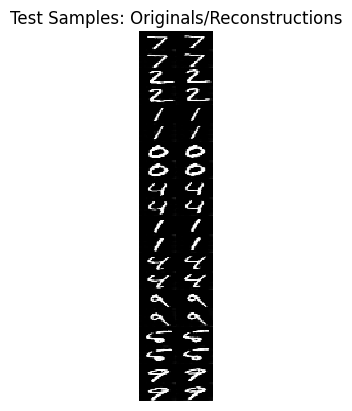

In [1]:
# -*- coding: utf-8 -*-
"""Untitled46.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1Wc51_InIYNhY_K-7KVfw3RTRzxNZxvhQ
"""

# -*- coding: utf-8 -*-
"""swwae.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1iPK2GFyYhy7tf2cF5qaT1YnWlQde08_3
"""

import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import Model
from tensorflow.keras.losses import Loss
from tensorflow.keras.layers import Layer, Conv2D, Input
import numpy as np
import matplotlib.pyplot as plt

class MaxPoolingWithArgmax2D(Layer):
    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        ksize = [1, pool_size[0], pool_size[1], 1]
        strides = [1, strides[0], strides[1], 1]
        output, argmax = tf.nn.max_pool_with_argmax(inputs, ksize, strides, 'SAME')
        argmax = tf.cast(argmax, tf.keras.backend.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx]
            if dim is not None else None
            for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]

class MaxUnpooling2D(Layer):
    def __init__(self, up_size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.up_size = up_size

    def unpool(self, pool, ind, ksize=[1, 2, 2, 1]):
        input_shape = tf.shape(pool)
        output_shape = [input_shape[0], input_shape[1] * ksize[1], input_shape[2] * ksize[2], input_shape[3]]

        flat_input_size = tf.math.reduce_prod(input_shape)
        flat_output_shape = [output_shape[0], output_shape[1] * output_shape[2] * output_shape[3]]

        pool_ = tf.reshape(pool, [flat_input_size])
        batch_range = tf.reshape(tf.range(tf.cast(output_shape[0], tf.int64), dtype=ind.dtype),
                                          shape=[input_shape[0], 1, 1, 1])
        b = tf.ones_like(ind) * batch_range
        b1 = tf.reshape(b, [flat_input_size, 1])
        ind_ = tf.reshape(ind, [flat_input_size, 1])
        ind_ = tf.concat([b1, ind_], 1)

        ret = tf.scatter_nd(ind_, pool_, shape=tf.cast(flat_output_shape, tf.int64))
        ret = tf.reshape(ret, output_shape)

        set_input_shape = pool.get_shape()
        set_output_shape = [set_input_shape[0], set_input_shape[1] * ksize[1], set_input_shape[2] * ksize[2], set_input_shape[3]]
        ret.set_shape(set_output_shape)
        return ret

    def call(self, inputs, output_shape=None):
        updates = inputs[0]
        mask    = tf.cast(inputs[1], dtype=tf.int64)
        ksize   = [1, self.up_size[0], self.up_size[1], 1]
        return self.unpool(updates, mask, ksize)

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.up_size[0],
            mask_shape[2] * self.up_size[1],
            mask_shape[3]
        )

class Encoder(Model):
    def __init__(self, input_dim):
        super(Encoder, self).__init__()
        self.input_1 = Input(shape=input_dim)
        self.conv1 = Conv2D(16, (5, 5), activation='relu', padding='same')
        self.conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.max_pool_argmax = MaxPoolingWithArgmax2D(pool_size=(7,7), strides=(7,7))

    def call(self, x):
        #x = self.input_1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x, mask_1 = self.max_pool_argmax(x)
        L2M_encoder_1 = x
        return x, mask_1, L2M_encoder_1

class Decoder(Model):
    def __init__(self, original_shape):
        super(Decoder, self).__init__()
        #self.input = Input(shape=input_dim)
        self.unpool_1 = MaxUnpooling2D((7,7))
        self.conv_1 = Conv2D(16, (3, 3), activation='relu', padding='same')
        self.conv_2 = Conv2D(1, (5, 5), activation='sigmoid', padding='same')

    def call(self, x):
        L2M_decoder_1 = x[0]
        x = self.unpool_1(x)
        x = self.conv_1(x)
        x = self.conv_2(x)
        return x, L2M_decoder_1

class SWWAE(Model):
    def __init__(self, input_dim):
        super(SWWAE, self).__init__()
        self.encoder = Encoder(input_dim)
        self.decoder = Decoder(input_dim)

    def compile(self, optimizer, loss):
        super().compile(optimizer)
        self.loss = loss

    def call(self, x):
        # Forward pass through the encoder and decoder
        encoded, mask_1, L2M_encoder_1 = self.encoder(x)
        decoded, L2M_decoder_1 = self.decoder([encoded, mask_1])
        return decoded, L2M_encoder_1, L2M_decoder_1

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train.astype('float32') / 255., -1)
x_test = np.expand_dims(x_test.astype('float32') / 255., -1)[:10, :, :, :]

x_train.shape

# class L2rec_L2M(Loss):
#     def __init__(self, L2rec_lambda=1, L2M_lambda=1):
#         self.L2rec_lambda = L2rec_lambda
#         self.L2M_lambda = L2M_lambda

def L2rec_L2M(y_true, y_pred, L2M_encoder_1, L2M_decoder_1):
    l2m_1 = tf.math.square(tf.math.subtract(L2M_encoder_1,L2M_decoder_1))
    L2rec = tf.math.square(tf.math.subtract(y_true,y_pred))
    return tf.math.add(tf.math.reduce_mean(l2m_1),tf.math.reduce_mean(L2rec))

input_dim = (28,28,1)
latent_dim = 2
model = SWWAE(input_dim)
optimizer = tf.optimizers.Adam()
loss = L2rec_L2M
model.compile(loss=loss, optimizer=optimizer)

# Commented out IPython magic to ensure Python compatibility.
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((x_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Randomly select a set of images for visualization
num_visualize = 10  # Number of images you want to visualize
# Identify indices for digits 0 through 9 in the training set
indices = []
for digit in range(10):
    indices.append(np.where(y_train == digit)[0][0])  # Get the index of the first occurrence of each digit

# Create the visualization set with one instance of each digit
visualization_set = x_train[indices]

num_images = len(visualization_set)
num_rows = 5
num_cols = 2

# Set the figure size based on the number of rows and columns
fig_width = 10
fig_height = 5 * num_rows  # Adjust this factor to control the vertical spacing

# Create the figure and iterate through images
fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))
for i in range(num_images):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    ax.imshow(visualization_set[i].squeeze(), cmap='gray', aspect='auto')
    ax.axis('off')

# Remove any empty subplots
for i in range(num_images, num_rows * num_cols):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()

import os
save_dir = 'saved_plots'
os.makedirs(save_dir, exist_ok=True)

filename = os.path.join(save_dir,  'targets.png')
plt.savefig(filename, bbox_inches='tight', pad_inches=0)  # Save the figure before showing it
#plt.show()  # Show the figure after saving it
plt.close()

# Verify if the visualization set contains the digits 0 through 9
assert np.all(np.sort(np.unique(y_train[indices])) == np.arange(10)), "Visualization set does not contain all digits 0-9"

epochs = 1
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train) in enumerate(train_dataset):
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            prediction, L2M_encoder_1, L2M_decoder_1 = model(x_batch_train, training=True)  # Logits for this minibatch
#             print('L2M_encoder_1',L2M_encoder_1.shape)
#             print('L2M_decoder_1',L2M_decoder_1.shape)
            # Compute the loss value for this minibatch.
            loss_value = loss(x_batch_train, prediction, L2M_encoder_1, L2M_decoder_1)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 200 batches.
        if step % 200 == 0:
          print("Training loss (for one batch) at step %d: %.4f" % (step, float(loss_value)))
          print("Seen so far: %s samples" % ((step + 1) * batch_size))

      # Predict on the visualization set

        predictions = model.predict(visualization_set)
        reconstructions = predictions[0]  # Assuming the decoded images are the first element

                # Calculate the number of rows and columns

        num_images = len(reconstructions)
        num_rows = 5
        num_cols = 2

        # Set the figure size based on the number of rows and columns
        fig_width = 10
        fig_height = 5 * num_rows  # Adjust this factor to control the vertical spacing

        # Create the figure and iterate through images
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))
        for i in range(num_images):
            row = i // num_cols
            col = i % num_cols
            ax = axs[row, col]
            ax.imshow(reconstructions[i].squeeze(), cmap='gray', aspect='auto')
            ax.axis('off')

        # Remove any empty subplots
        for i in range(num_images, num_rows * num_cols):
            fig.delaxes(axs.flatten()[i])

        plt.tight_layout()
        filename = os.path.join(save_dir, str(step) + '.png')
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)  # Save the figure before showing it
        #plt.show()  # Show the figure after saving it
        plt.close()



x_recon = model.predict(x_test[:25])
x_plot = np.concatenate((x_test[:25], x_recon[0]), axis=1)
print(x_plot.shape)
x_plot = x_plot.reshape((28,1,10,56))
x_plot = np.vstack([np.hstack(x) for x in x_plot])
plt.figure()
plt.axis('off')
plt.title('Test Samples: Originals/Reconstructions')
plt.imshow(x_plot, interpolation='none', cmap='gray')
plt.savefig('reconstructions.png')


In [3]:
!zip -r /content/saved_plots.zip /content/saved_plots

  adding: content/saved_plots/ (stored 0%)
  adding: content/saved_plots/922.png (deflated 50%)
  adding: content/saved_plots/52.png (deflated 48%)
  adding: content/saved_plots/782.png (deflated 50%)
  adding: content/saved_plots/665.png (deflated 50%)
  adding: content/saved_plots/360.png (deflated 48%)
  adding: content/saved_plots/451.png (deflated 49%)
  adding: content/saved_plots/1318.png (deflated 50%)
  adding: content/saved_plots/594.png (deflated 49%)
  adding: content/saved_plots/705.png (deflated 49%)
  adding: content/saved_plots/1647.png (deflated 51%)
  adding: content/saved_plots/305.png (deflated 48%)
  adding: content/saved_plots/470.png (deflated 49%)
  adding: content/saved_plots/1247.png (deflated 52%)
  adding: content/saved_plots/255.png (deflated 49%)
  adding: content/saved_plots/402.png (deflated 49%)
  adding: content/saved_plots/71.png (deflated 47%)
  adding: content/saved_plots/564.png (deflated 49%)
  adding: content/saved_plots/632.png (deflated 49%)
  

In [6]:
import os
import cv2

# Input directory containing PNG files
input_directory = '/content/saved_plots'

# Output video file name
output_video = 'output.mp4'

# Get a list of all PNG files in the directory and sort them by numerical order
png_files = [f for f in os.listdir(input_directory) if f.endswith('.png') and f != 'targets.png']
png_files.sort(key=lambda x: int(os.path.splitext(x)[0]))

# Set the frame size based on the first image's dimensions
first_image = cv2.imread(os.path.join(input_directory, png_files[0]))
frame_size = (first_image.shape[1], first_image.shape[0])

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video, fourcc, 30.0, frame_size)

# Iterate through non-"targets.png" PNG files and add them to the video
for png_file in png_files:
    img = cv2.imread(os.path.join(input_directory, png_file))
    out.write(img)

# Release the VideoWriter object and close the display window if necessary
out.release()
cv2.destroyAllWindows()
